In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Sc.sgd.db)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [2]:
#background gene list
setwd('/home/david/Documents/ghsom')
allGenes <- scan("Uetz_screen.txt", character())
allGenes <- unique(allGenes) 

In [3]:
##load all community gene lists
setwd("/home/david/Documents/ghsom/uetz_communities")

g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}
# numCom <- numCom + 1
# numCom
numCom

[1] 9

In [4]:
#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [6]:
cutOff <- 0.05

geneLists <- vector("list", numCom) 
GOdataObjects <- vector("list", numCom) 
resultFishers <- vector("list", numCom) 
resultFisher.elims <- vector("list", numCom) 
results <- vector("list", numCom) 
topResults <- vector("list", numCom) 
gos <- vector("list", numCom) 

#perform enrichment analyses
for (c in 1:numCom){
    
    #factor of interesting genes
    geneList <- factor(as.integer(allGenes %in% g[[c]]))
    names(geneList) <- allGenes
    geneLists[[c]] <- geneList
    
    #construct topGO object
    GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                  ontology = "BP", allGenes = geneList,
                  annotationFun = annFUN.org, mapping = "org.Sc.sgd.db", 
                  ID = "ENSEMBL", nodeSize = 10)
    GOdataObjects[[c]] <- GOdata
    
#     #fishers exact test classic
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultFishers[[c]] <- resultFisher
    
#     #fishers exact test elimination
    resultFisher.elim <- runTest(GOdata, algorithm = "elim", statistic = "fisher")
    resultFisher.elims[[c]] <- resultFisher.elim
    
    #tabulate results
    allRes <- GenTable(GOdata, classicFisher = resultFisher,
                  elimFisher = resultFisher.elim,
                  orderBy = "classicFisher", topNodes = 500)
    results[[c]] <- allRes
    
    #go terms <0.01 on both tests
    topResults[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)
    gos[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)$GO.ID
}


Building most specific GOs .....
	( 1106 GO terms found. )

Build GO DAG topology ..........
	( 2835 GO terms and 6413 relations. )

Annotating nodes ...............
	( 770 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 458 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 458 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 13:	2 nodes to be scored	(0 eliminated genes)

	 Level 12:	3 nodes to be scored	(0 eliminated genes)

	 Level 11:	7 nodes to be scored	(0 eliminated genes)

	 Level 10:	15 nodes to be scored	(0 eliminated genes)

	 Level 9:	28 nodes to be scored	(0 eliminated genes)

	 Level 8:	42 nodes to be scored	(0 eliminated genes)

	 Level 7:	60 nodes to be scored	(0 eliminated genes)

	 Level 6:	80 nodes to be scored	(0 eliminated genes)

	 Level 5:	101 nodes to be scored	(0 eliminated genes)

	 Level 4:	76 nodes to be scored	

In [7]:
typeof(topResults[[5]])

[1] "list"

In [8]:
dir.create("/home/david/Documents/ghsom/uetz_go_terms")
setwd("/home/david/Documents/ghsom/uetz_go_terms")
for (c in 1:numCom){
    write.csv(topResults[[c]], sprintf("go_terms_%s", c))
    print(sprintf("saved terms %s", c))
} 

[1] "saved terms 1"
[1] "saved terms 2"
[1] "saved terms 3"
[1] "saved terms 4"
[1] "saved terms 5"
[1] "saved terms 6"
[1] "saved terms 7"
[1] "saved terms 8"
[1] "saved terms 9"


In [9]:
##semantic similarity
library(GOSemSim)
scGO <- godata('org.Sc.sgd.db',  ont="BP", keytype="ENSEMBL")

GOSemSim v2.0.4  For help: https://guangchuangyu.github.io/GOSemSim

If you use GOSemSim in published research, please cite:
Guangchuang Yu, Fei Li, Yide Qin, Xiaochen Bo, Yibo Wu, Shengqi Wang. GOSemSim: an R package for measuring semantic similarity among GO terms and gene products Bioinformatics 2010, 26(7):976-978


[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [7]:
distances <- numeric((numCom * (numCom - 1)) / 2)
semSims <- numeric((numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:numCom) {
    
#     gs1 <- g[[c1]]
    if (length(gos[[c1]]) == 0) next
    
    for (c2 in c1:numCom) {
        
        if (c1 == c2) next
            
        if (length(gos[[c2]]) == 0) next
            
#         gs2 <- g[[c2]]    
        
        completed <- completed + 1  
        
        #compute semantic similarity of two protein clusters
#         semSims[completed] <- clusterSim(gs1, gs2, semData=scGO, measure="Wang", combine="BMA")
        semSims[completed] <- mgoSim(gos[[c1]], gos[[c2]], semData=scGO, measure="Wang", combine="BMA")
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}
distances <- distances[distances > 0]
semSims <- semSims[semSims > 0]

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

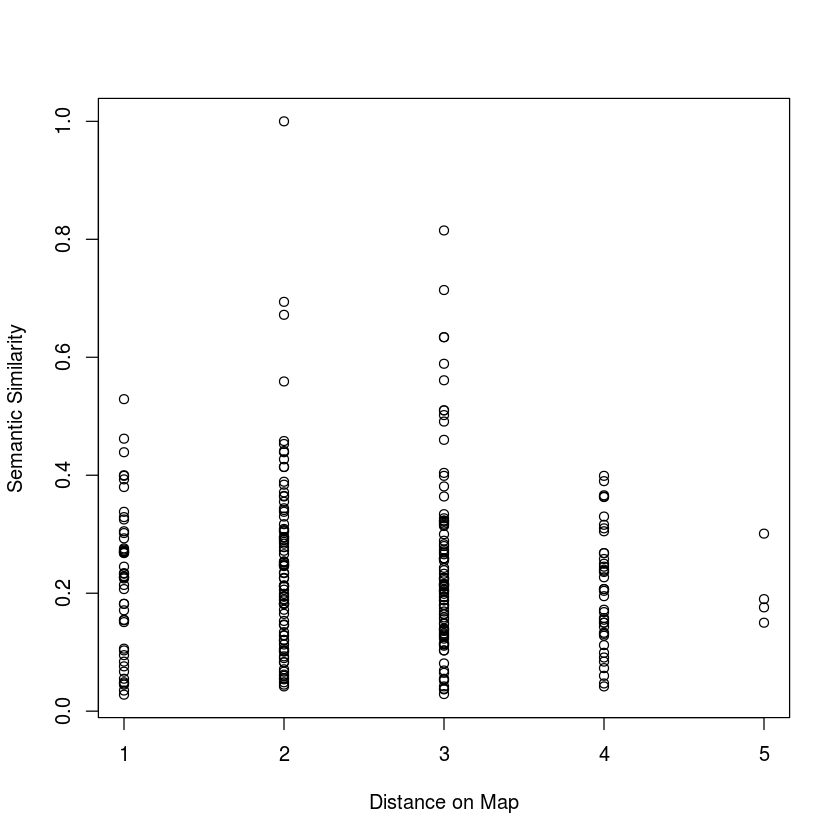

In [8]:
plot(distances, semSims, xlab="Distance on Map", ylab="Semantic Similarity")

In [9]:
cor(distances, semSims)

[1] -0.03924858